# Analysis on the baby names of NY state (2007-2012)

## Tables of contents

1\. [Names Distribution overview](#name-distrib-overview)\
&nbsp; &nbsp; 1\.1\. Most popular names across NY state\
&nbsp; &nbsp; 1\.2\. Evolution of the baby names for each NY county and year\
&nbsp; &nbsp; &nbsp; 1\.2\.1\.  Computing a dataframe with the counties with a drop in 2010\
&nbsp; &nbsp; &nbsp; 1\.2\.2\.  Assessing if the baby names for each county is normal in terms of overall population and birth rate\
&nbsp; &nbsp; 1\.3\. Diversity of name distribution per county\
&nbsp; &nbsp; 1\.4\. Relationships between different created name distribution variables\
&nbsp; &nbsp; 1\.5\.  Clustering analysis of the counties\
&nbsp; &nbsp; &nbsp; 1\.5\.1\.  Distribution of names in each county\
&nbsp; &nbsp; &nbsp; 1\.5\.2\. Which county may be more representative of the whole NY state in terms of name distribution?\
&nbsp; &nbsp; &nbsp; 1\.5\.3\. Which counties can be grouped together in terms of the name distribution?\

2\. [Name origin overview](#origin-distrib-overview)\
&nbsp; &nbsp; 2\.1\. Most common origin present in the whole state of NY\
&nbsp; &nbsp; 2\.2\. Distribution of the most comon origin name in NY State (Dutch) by County\
&nbsp; &nbsp; 2\.3\. Most common name origin by county and year

#### Import libraries

In [47]:

# !pip install plotly
# !pip install chart_studio

In [48]:
import numpy as np
import pandas as pd

#We import the necessary libraries for visualization. We set seaborn do be our default
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
sns.set()
%matplotlib inline

# !pip install plotly
# !pip install chart_studio
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering 

import dtale

from wordcloud import WordCloud, STOPWORDS

style.use('seaborn-paper')
plt.rcParams["figure.figsize"] = (12, 10)
plt.rcParams["figure.dpi"] = 100


from urllib.request import urlopen
import json

import warnings
warnings.filterwarnings("ignore")

## 0. Preparation

### 0.1. Loading data

#### 0.1.1 Baby Names NY 2007-2012

In [49]:
names_no_origin = pd.read_csv('Data/Baby_Names_Beginning_2007.csv', sep = ',', header = 0)
# names_no_origin = pd.read_csv('Baby_Names_Beginning_2007.csv', sep = ',', header = 0, parse_dates=[0])
names_no_origin = names_no_origin.rename(columns={"First Name": "First_Name"})
names_no_origin.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35217 entries, 0 to 35216
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year        35217 non-null  int64 
 1   First_Name  35217 non-null  object
 2   County      35217 non-null  object
 3   Sex         35217 non-null  object
 4   Count       35217 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.3+ MB


#### 0.1.2 Origin Names

In [50]:
origin = pd.read_csv('Data/Names_Origins.csv', sep = ';', header = 0, usecols = [0, 1])
origin = origin.rename(columns={"First Name": "First_Name"})
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1559 entries, 0 to 1558
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   First_Name  1559 non-null   object
 1   Origin      1559 non-null   object
dtypes: object(2)
memory usage: 24.5+ KB


#### 0.1.3 County Data USA

In [51]:
county_data =pd.read_csv('Data/minoritymajority.csv',sep=',',header=0,usecols = [0,1,2,3,4,5])
county_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3143 entries, 0 to 3142
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   FIPS        3143 non-null   int64 
 1   STNAME      3143 non-null   object
 2   CTYNAME     3143 non-null   object
 3   TOT_POP     3143 non-null   int64 
 4   TOT_MALE    3143 non-null   int64 
 5   TOT_FEMALE  3143 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 147.5+ KB


In [52]:
county_data = county_data[county_data.STNAME == 'New York']
county_data['County'] = county_data['CTYNAME'].map(lambda x: x.rsplit()[0])
county_data['County'] = county_data['County'].str.upper()
# dtale.show(county_data)
county_data.loc[county_data.County == 'ST.', 'County'] = 'ST LAWRENCE'
county_data.loc[county_data.County == 'NEW', 'County'] = 'NEW YORK'
# dtale.show(county_data,ignore_duplicate=True)


#### 0.2.1 Data Aggregation and Data Cleaning

In [53]:
# Join names_no_origin and origin dataframes on First_Name key
names = pd.merge(names_no_origin,origin, how = 'left', on = 'First_Name' )
names = pd.merge(names,county_data[['County','FIPS']], how = 'left', on = 'County')
names.head()

,Year,First_Name,County,Sex,Count,Origin,FIPS
0,2012,DOMINIC,CAYUGA,M,6,Chinese,36011
1,2012,ADDISON,ONONDAGA,F,14,African American,36067
2,2012,JULIA,ONONDAGA,F,15,English,36067
3,2012,WILLIAM,WESTCHESTER,M,41,Italian,36119
4,2012,AMELIA,ONONDAGA,F,15,Hawaiian,36067


In [54]:
# Checking for missing values
names[names.columns[names.isnull().any()]].isnull().sum()

Series([], dtype: float64)

#### 0.3.1 Quick analysis on the baby gender

There are **more babies with names that are male**. This is strange since this difference can not be attributed to natural causes. There might be some **mislabelling in the names** or the the baby sex is extracted from the name and some names can be used for both genders. It could be **interesting to look if there are names that are used in both genders.**

In [55]:
sex_year_table = pd.pivot_table(names,index=["Year"],columns=["Sex"],values=["Count"],aggfunc=sum, margins=True, 
                       dropna=True, fill_value=0)
sex_year_table = sex_year_table.div( sex_year_table.iloc[:,-1], axis=0 ).style.background_gradient(cmap='Greens').format("{:.2%}")
sex_year_table

The decrease in 2010 is caused by having 0 baby names recorded in many counties, with a preponderance of 0 baby names females

In [56]:
county_sex_year_table = pd.pivot_table(names,index=["Year",'Sex'],columns=["County"],values=["Count"],aggfunc=sum, margins=True, 
                       dropna=True, fill_value=0)
# county_sex_year_table = county_sex_year_table.div( county_sex_year_table.iloc[:,-1], axis=0 ).style.background_gradient(cmap='Greens').format("{:.2%}")
county_sex_year_table

Count                                                               \
County   ALBANY ALLEGANY  BRONX BROOME CATTARAUGUS CAYUGA CHAUTAUQUA CHEMUNG   
Year Sex                                                                       
2007 F      431        5   3662    247          52     35        124      51   
     M      779       24   6032    484         134    112        255     144   
2008 F      419       10   3759    237          53     30        137      29   
     M      685       28   6395    462         114    128        231     112   
2009 F      420       10   3848    184          71     29        130      40   
     M      673       24   6290    473         108     97        233      98   
2010 F      188        0   3741     58           0     10          0       0   
     M      411        0   6055    180           0     10         69      25   
2011 F      396       11   3720    221          30     33         72      37   
     M      697       14   5807    403          73     78        197     160   
2012 F      376        0   3352    194          39     41         64      51   
     M      598       15   5893    442         102     97        206     124   
All        6073      141  58554   3585         776    700       1718     871   

                           ...                                                \
County   CHENANGO CLINTON  ... TIOGA TOMPKINS ULSTER WARREN WASHINGTON WAYNE   
Year Sex                   ...                                                 
2007 F         32      27  ...    17       29    282     26         54    94   
     M         29      95  ...    23      101    405     78         43   164   
2008 F         16      51  ...    27       33    181     37         34    66   
     M         16      76  ...    21       90    378     72         46   172   
2009 F         12      33  ...     0       34    168     53         10   104   
     M          5      54  ...     0       61    364     58         63   173   
2010 F          0       0  ...     0        0     59      0          0     0   
     M          0      11  ...     0        0     89      0          0     0   
2011 F         15      40  ...    11       55    171     12         14    81   
     M         24      70  ...    19       76    305     46         70   134   
2012 F         20      44  ...     6       36    142     10          5    58   
     M         22      40  ...     6       46    271     27         61    99   
All           191     541  ...   130      561   2815    419        400  1145   

                                            
County   WESTCHESTER WYOMING YATES     All  
Year Sex                                    
2007 F          3286       0     0   50604  
     M          4090      17     0   69515  
2008 F          2489       5     0   49990  
     M          3253       5     0   70482  
2009 F          2914      15     0   49381  
     M          3816      11    16   69199  
2010 F          2064       0     0   40914  
     M          3257       0     0   59499  
2011 F          2707       5     0   48386  
     M          3704       7     0   66891  
2012 F          2751       5     0   47539  
     M          3473       7     0   66497  
All            37804      77    16  688897  

[13 rows x 62 columns]

There is a **downward trend in the babies per year in both genders**. Besides, in year 2010, **there were much less babies** born for both genders.

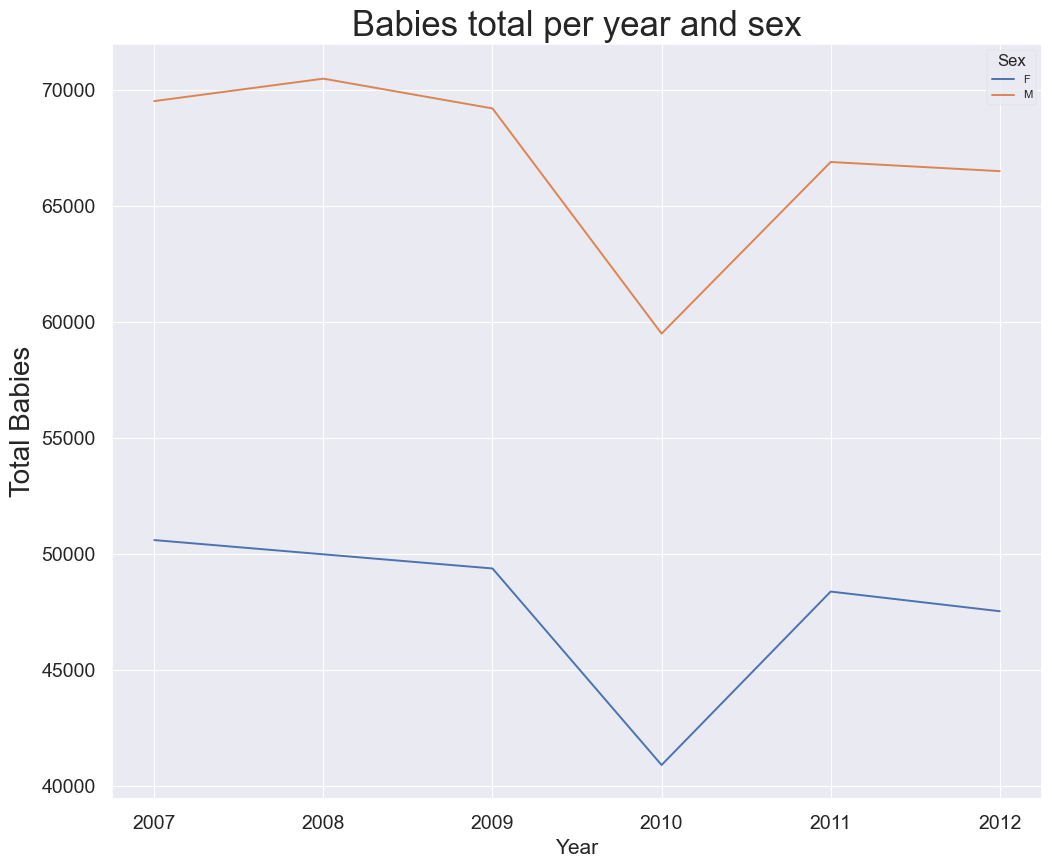

In [57]:
sex_year = names.groupby(['Year','Sex'])['Count'].sum().reset_index()
sns.lineplot(x='Year', y='Count', data=sex_year, hue = 'Sex')
plt.title('Babies total per year and sex',fontsize=25)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Total Babies',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [58]:
names_per_genre = names.groupby(['First_Name','Sex'])['Count'].sum().reset_index()
names_per_genre[names_per_genre.First_Name == 'ALEXIS']

,First_Name,Sex,Count
64,ALEXIS,F,1466
65,ALEXIS,M,477


Out of the 1559 unique names, **there are 29 that can be used both for male and female gender**. This is unlikely to explain neither the the decrease in the 2010 year in the baby names nor the considerably higher proportion to 50% of males than females

In [59]:
names_per_genre_repeated = names_per_genre.pivot_table(index=['First_Name'], aggfunc='size').reset_index()
names_per_genre_repeated.columns = ['First_Name', 'Both_genders']
names_per_genre_repeated.sort_values(by='Both_genders', ascending=False)
names_per_genre_repeated.groupby('Both_genders').count()

,First_Name
Both_genders,
1,1530
2,29


<a name="name-distrib-overview"></a>

## 1. Names Distribution overview

### 1.1. Most popular names across NY state


These are the 20 (out of 1559 names) most popular names for babies in NY between 2007-2012

**Calculate the proportion of each name across all years and in the whole NY state**

In [60]:
state_names_distribution = names.groupby('First_Name')['Count'].sum().reset_index().sort_values(by='Count', ascending=False)
state_names_distribution['Count_%'] = state_names_distribution['Count'] / state_names_distribution['Count'].sum() * 100
most_common_names = state_names_distribution.nlargest(400, 'Count')['First_Name'].tolist()
state_names_distribution.head(20)

,First_Name,Count,Count_%
1105,MICHAEL,9187,1.333581
1067,MATTHEW,7891,1.145454
743,JAYDEN,7807,1.133261
667,ISABELLA,7782,1.129632
799,JOSEPH,7609,1.104519
688,JACOB,7444,1.080568
149,ANTHONY,7427,1.078100
389,DANIEL,7313,1.061552
1401,SOPHIA,7274,1.055891
1298,RYAN,7172,1.041085


**WordCloud visualization of the most popular names in NY State**

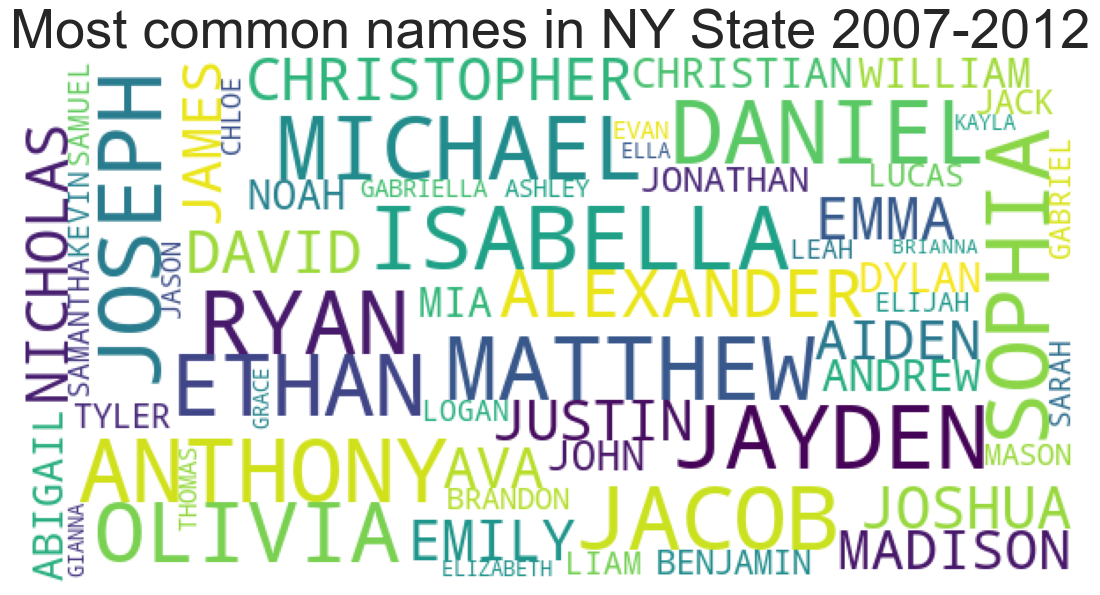

In [61]:
wordcloud = WordCloud( max_font_size=50, 
                       stopwords=STOPWORDS,
                       background_color='white',
                       width=600, height=300
                     ).generate(" ".join(state_names_distribution.nlargest(60, 'Count')['First_Name'].tolist()))

plt.figure(figsize=(14,7))
plt.title("Most common names in NY State 2007-2012", fontsize=39)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Evolution of the 10 most popular names in NY State**

In [62]:
state_names_distribution_year = names.groupby(['First_Name','Year'])['Count'].sum().reset_index().sort_values(by='Count', ascending=False)
state_names_distribution_year['Count_%'] = state_names_distribution_year['Count'] / state_names_distribution_year['Count'].sum() * 100
ten_most_common_names = state_names_distribution.nlargest(10, 'Count')['First_Name'].tolist()
state_names_distribution_year = state_names_distribution_year[state_names_distribution_year['First_Name'].isin(ten_most_common_names)]

It is interesting to see the downward trend of the 10 most popular names. Each year less babies are named with the most common names

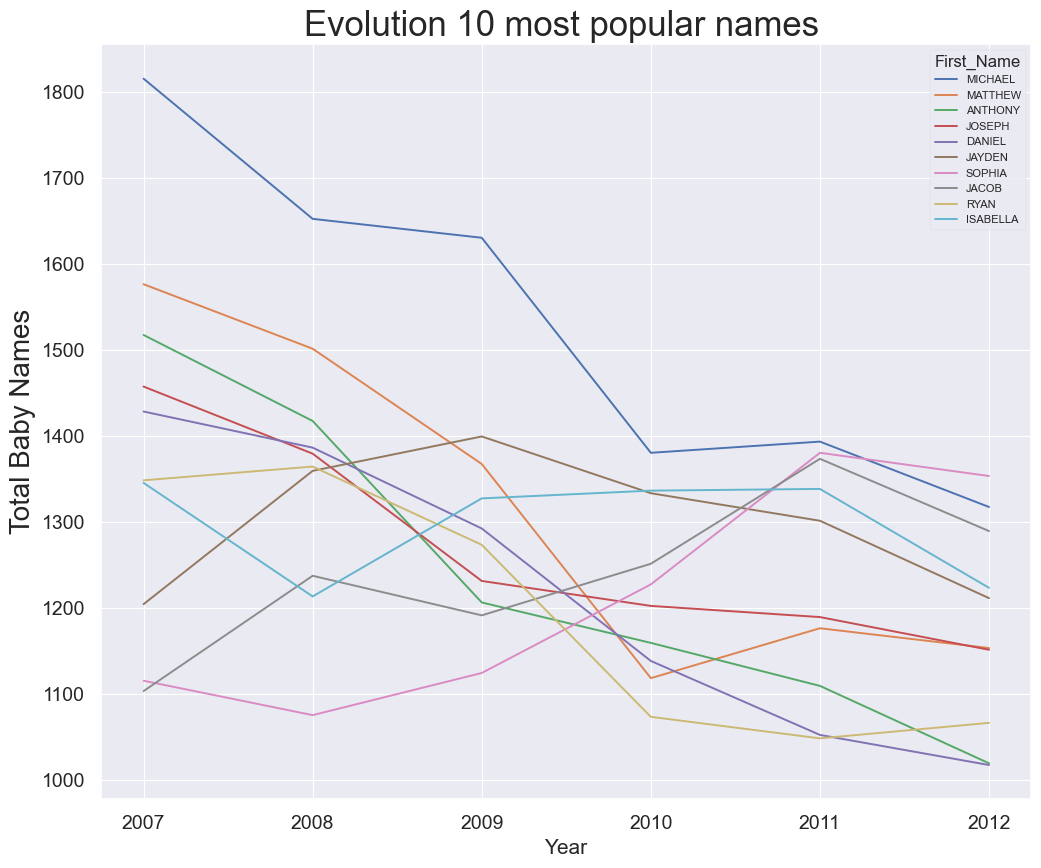

In [63]:
sns.lineplot(x='Year', y='Count', data=state_names_distribution_year, hue = 'First_Name')
plt.title('Evolution 10 most popular names ',fontsize=25)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Total Baby Names',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Let's see if the names are equally distributed among all NY counties

### 1.2. Evolution of the babies for each NY county and year

There are many counties with a lot of new baby born (the ones from NY city) whereas the majority have less than 3000 new babies during the period (as shown with the blue line)

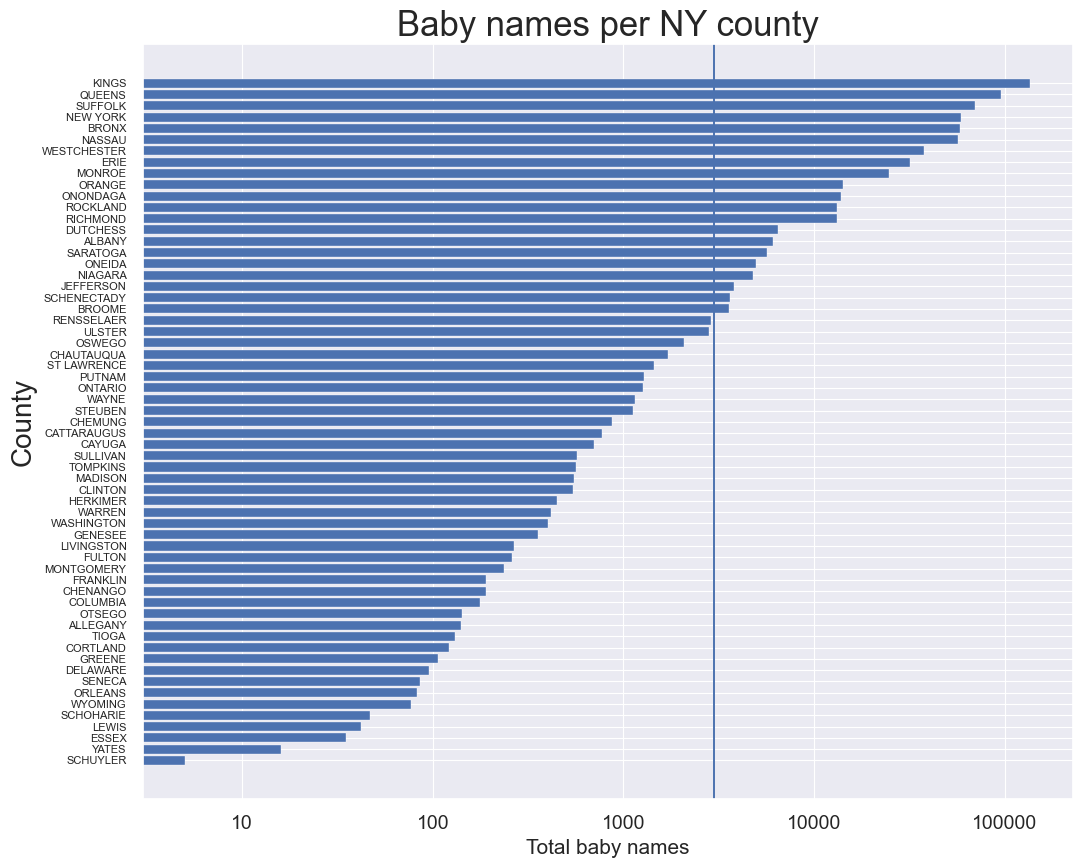

In [64]:
names_per_county = names.groupby(['County'])['Count'].sum().reset_index().sort_values(by='Count', ascending=True)
plt.barh(names_per_county.County,names_per_county.Count,log=True)
ax = plt.axes()
plt.title('Baby names per NY county',fontsize=25)
plt.axvline(3000, 0,1)
plt.xlabel('Total baby names',fontsize=15)
plt.ylabel('County',fontsize=20)
plt.xticks(fontsize=14)
ax.xaxis.set_major_formatter(plt.ScalarFormatter())


It would be interesting to check if the babies are **distributed equally across the years in each state and if in some states the babies bornt decreased whereas in other increased**

In [65]:
names_per_county_year = names.groupby(['County','Year'])['Count'].sum().reset_index().sort_values(by='Count', ascending=True)
names_per_county_year[names_per_county_year.County == 'BRONX'].sort_values(by='Year', ascending=True)

,County,Year,Count
11,BRONX,2007,9694
12,BRONX,2008,10154
13,BRONX,2009,10138
14,BRONX,2010,9796
15,BRONX,2011,9527
16,BRONX,2012,9245


The **counties with more than 1000 baby names in the dataset each year do not have the unusual decrease of baby names in 2010**. This decrease in 2010 **only happens to the majority of counties with less than 1000 baby** names each year. It would be interesting to create a variable to filter those counties with this extrange drop.


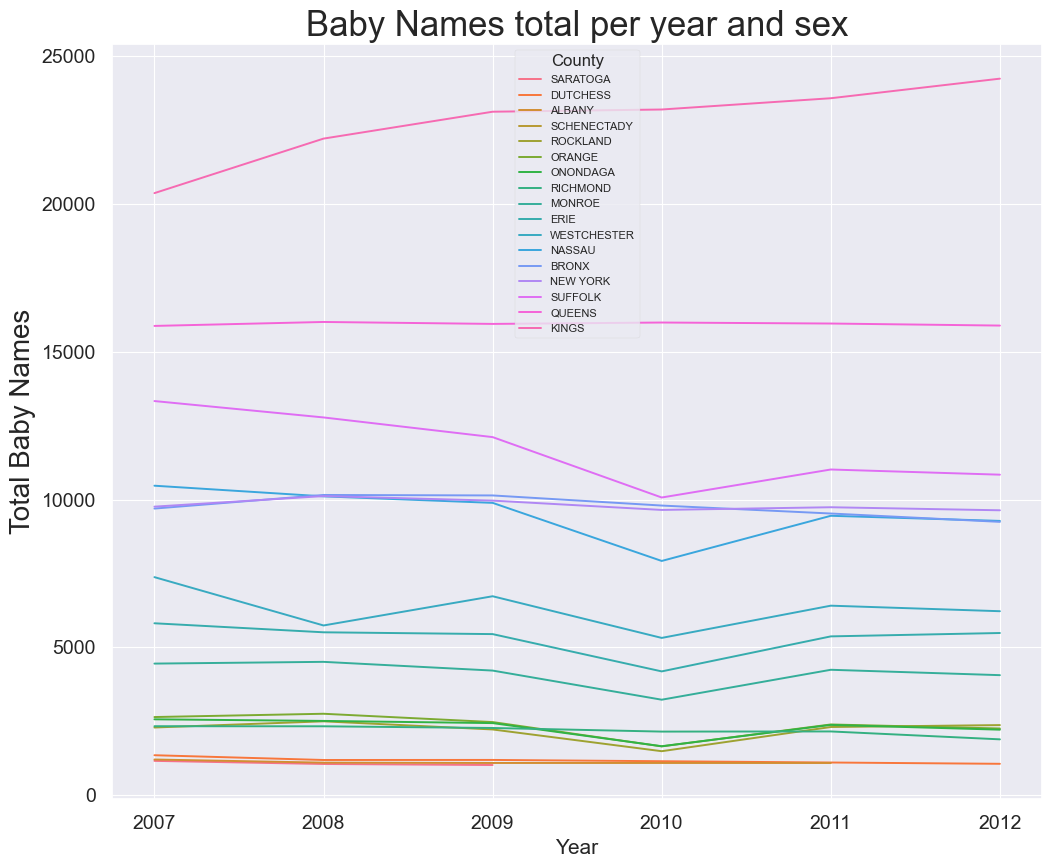

In [66]:
data = names_per_county_year[names_per_county_year.Count > 1000]
sns.lineplot(x='Year', y='Count', data=data, hue = 'County')
plt.title('Baby Names total per year and sex',fontsize=25)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Total Baby Names',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

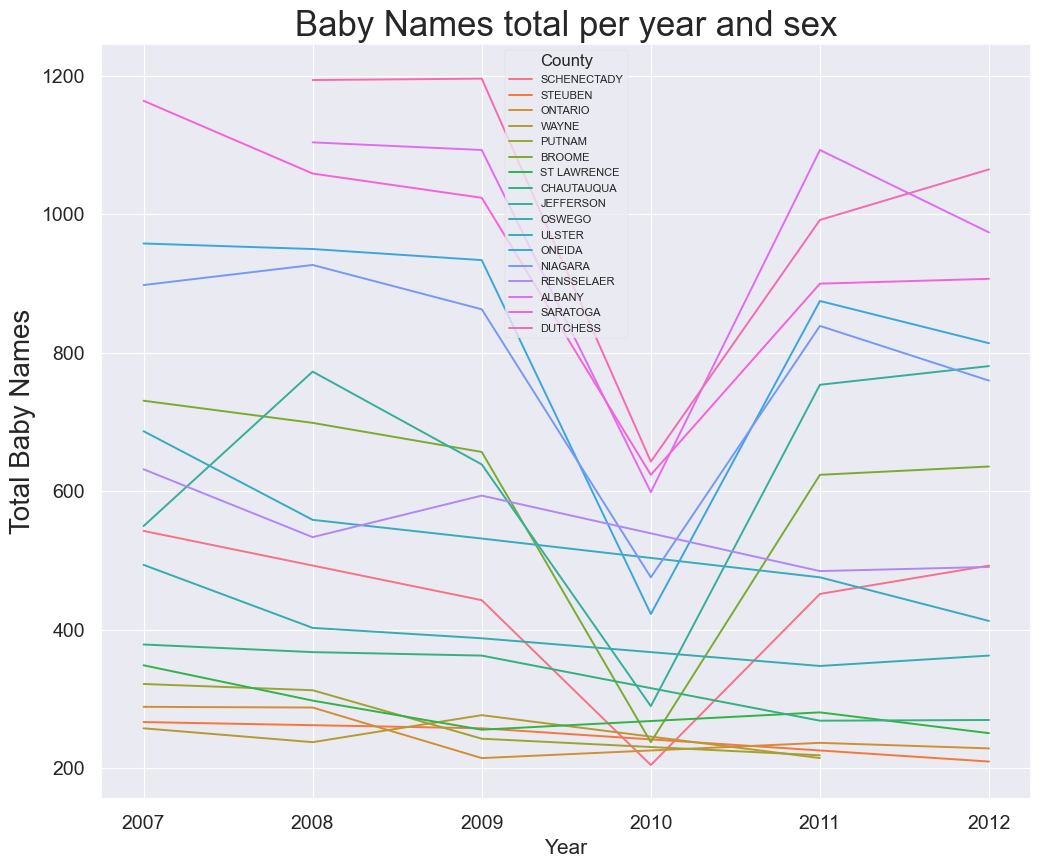

In [67]:
data = names_per_county_year[(names_per_county_year.Count <= 1200) & (names_per_county_year.Count > 200)]
sns.lineplot(x='Year', y='Count', data=data, hue = 'County')
plt.title('Baby Names total per year and sex',fontsize=25)
plt.xlabel('Year',fontsize=15)
ax = plt.axes()
plt.ylabel('Total Baby Names',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

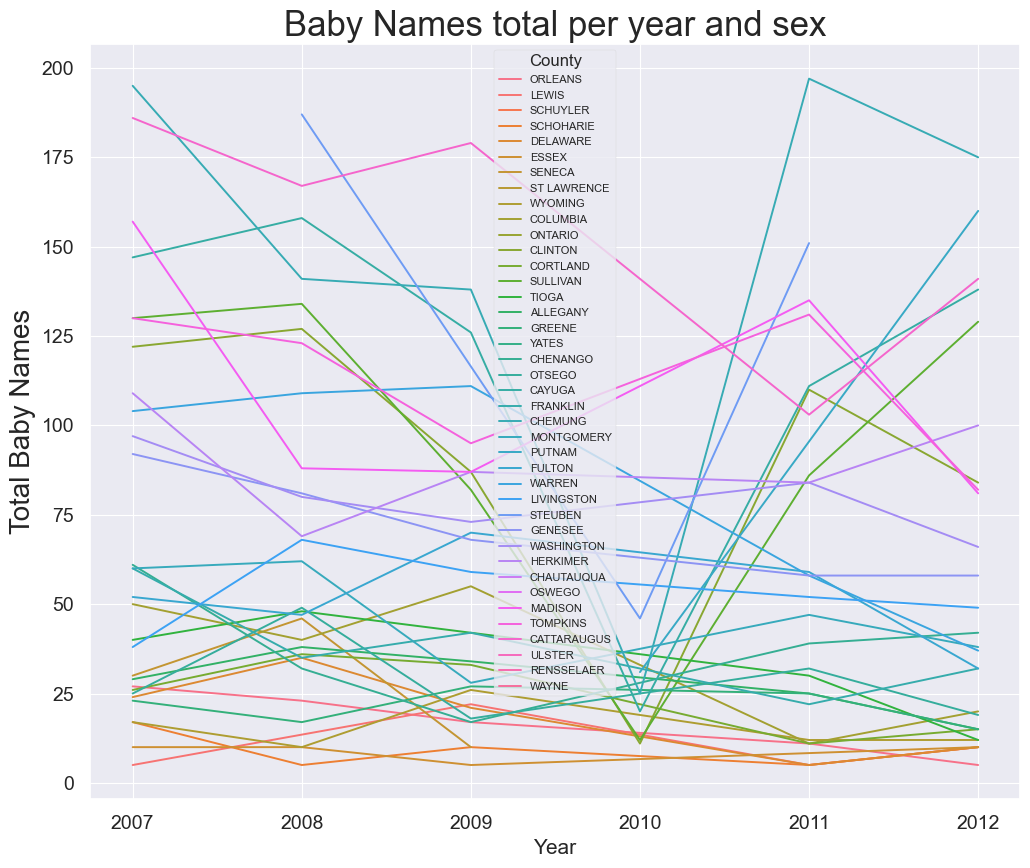

In [68]:
data = names_per_county_year[(names_per_county_year.Count <= 200)]
sns.lineplot(x='Year', y='Count', data=data, hue = 'County')
plt.title('Baby Names total per year and sex',fontsize=25)
plt.xlabel('Year',fontsize=15)
ax = plt.axes()
plt.ylabel('Total Baby Names',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### 1.2.1 Computing a dataframe with the counties with a drop in 2010

Those counties that have this huge decrease in the baby names in 2010 might pose a problem in terms of lack of data and it is better to single them out (moreover these are the states that have less baby names) and perform the analysis with the counties that  have more coherent baby names count over the years

In [69]:
table = pd.pivot_table(names_per_county_year, values=["Count"],
                       index=["Year"], columns=["County"], 
                       aggfunc=np.sum, margins=True, 
                       dropna=True, fill_value=0)
table

Count                                                               \
County ALBANY ALLEGANY  BRONX BROOME CATTARAUGUS CAYUGA CHAUTAUQUA CHEMUNG   
Year                                                                         
2007     1210       29   9694    731         186    147        379     195   
2008     1104       38  10154    699         167    158        368     141   
2009     1093       34  10138    657         179    126        363     138   
2010      599        0   9796    238           0     20         69      25   
2011     1093       25   9527    624         103    111        269     197   
2012      974       15   9245    636         141    138        270     175   
All      6073      141  58554   3585         776    700       1718     871   

                         ...                                                \
County CHENANGO CLINTON  ... TIOGA TOMPKINS ULSTER WARREN WASHINGTON WAYNE   
Year                     ...                                                 
2007         61     122  ...    40      130    687    104         97   258   
2008         32     127  ...    48      123    559    109         80   238   
2009         17      87  ...     0       95    532    111         73   277   
2010          0      11  ...     0        0    148      0          0     0   
2011         39     110  ...    30      131    476     58         84   215   
2012         42      84  ...    12       82    413     37         66   157   
All         191     541  ...   130      561   2815    419        400  1145   

                                          
County WESTCHESTER WYOMING YATES     All  
Year                                      
2007          7376      17     0  120119  
2008          5742      10     0  120472  
2009          6730      26    16  118580  
2010          5321       0     0  100413  
2011          6411      12     0  115277  
2012          6224      12     0  114036  
All          37804      77    16  688897  

[7 rows x 62 columns]

In [70]:
table_prop = pd.pivot_table(names_per_county_year, values=["Count"],
                       index=["Year"], columns=["County"], 
                       aggfunc=np.sum, margins=False, 
                       dropna=True, fill_value=0)
table_prop = table_prop.div( table_prop.max())
table_prop

Count                                                      \
County    ALBANY  ALLEGANY     BRONX    BROOME CATTARAUGUS    CAYUGA   
Year                                                                   
2007    1.000000  0.763158  0.954698  1.000000    1.000000  0.930380   
2008    0.912397  1.000000  1.000000  0.956224    0.897849  1.000000   
2009    0.903306  0.894737  0.998424  0.898769    0.962366  0.797468   
2010    0.495041  0.000000  0.964743  0.325581    0.000000  0.126582   
2011    0.903306  0.657895  0.938251  0.853625    0.553763  0.702532   
2012    0.804959  0.394737  0.910479  0.870041    0.758065  0.873418   

                                                 ...                      \
County CHAUTAUQUA   CHEMUNG  CHENANGO   CLINTON  ...  SULLIVAN     TIOGA   
Year                                             ...                       
2007     1.000000  0.989848  1.000000  0.960630  ...  0.970149  0.833333   
2008     0.970976  0.715736  0.524590  1.000000  ...  1.000000  1.000000   
2009     0.957784  0.700508  0.278689  0.685039  ...  0.611940  0.000000   
2010     0.182058  0.126904  0.000000  0.086614  ...  0.089552  0.000000   
2011     0.709763  1.000000  0.639344  0.866142  ...  0.641791  0.625000   
2012     0.712401  0.888325  0.688525  0.661417  ...  0.962687  0.250000   

                                                                       \
County  TOMPKINS    ULSTER    WARREN WASHINGTON     WAYNE WESTCHESTER   
Year                                                                    
2007    0.992366  1.000000  0.936937   1.000000  0.931408    1.000000   
2008    0.938931  0.813683  0.981982   0.824742  0.859206    0.778471   
2009    0.725191  0.774381  1.000000   0.752577  1.000000    0.912419   
2010    0.000000  0.215429  0.000000   0.000000  0.000000    0.721394   
2011    1.000000  0.692868  0.522523   0.865979  0.776173    0.869170   
2012    0.625954  0.601164  0.333333   0.680412  0.566787    0.843818   

                        
County   WYOMING YATES  
Year                    
2007    0.653846   0.0  
2008    0.384615   0.0  
2009    1.000000   1.0  
2010    0.000000   0.0  
2011    0.461538   0.0  
2012    0.461538   0.0  

[6 rows x 61 columns]

In [71]:
table_prop_2010 = table_prop.loc[2010].reset_index() 
table_prop_2010 = table_prop_2010.iloc[:,1:3]
table_prop_2010.columns = ['County', 'pct_pop_2010']
counties_pop_decrease = table_prop_2010
counties_pop_decrease['Decrease_2010_pop'] = True
counties_pop_decrease.loc[counties_pop_decrease['pct_pop_2010']>0.7,'Decrease_2010_pop'] = False
counties_pop_decrease = counties_pop_decrease.drop(['pct_pop_2010'],axis=1)
counties_pop_decrease.head()

,County,Decrease_2010_pop
0,ALBANY,True
1,ALLEGANY,True
2,BRONX,False
3,BROOME,True
4,CATTARAUGUS,True


It seems that some counties have very few new babies registered like WYOMING or YATES (9 of them less than 100 in the 2007-2012 period). It would be interest to check if all these counties have a similar rate of births regarding their population.

#### 1.2.2 Assessing if the baby names for each county is normal in terms of overall population and birth rate

In [72]:
names_per_county_year.head()

,County,Year,Count
196,ORLEANS,2012,5
125,LEWIS,2007,5
127,LEWIS,2011,5
255,SCHUYLER,2007,5
253,SCHOHARIE,2011,5


In [73]:
county_data.head() 

,FIPS,STNAME,CTYNAME,TOT_POP,TOT_MALE,TOT_FEMALE,County
1102,36001,New York,Albany County,305455,147620,157835,ALBANY
1103,36003,New York,Allegany County,48357,24415,23942,ALLEGANY
1104,36005,New York,Bronx County,1408473,663210,745263,BRONX
1105,36007,New York,Broome County,198060,97061,100999,BROOME
1106,36009,New York,Cattaraugus County,79458,39285,40173,CATTARAUGUS


In [74]:
county_data.groupby('STNAME')['TOT_POP'].sum().reset_index()

,STNAME,TOT_POP
0,New York,19570261


In [75]:
county_total_names_plus_population = pd.merge(names_per_county_year,county_data[['County','FIPS','TOT_POP','TOT_MALE','TOT_FEMALE']], how = 'left', on = 'County')
county_total_names_plus_population.isnull().any()
# dtale.show(county_total_names_plus_population,ignore_duplicate=True)

County        False
Year          False
Count         False
FIPS          False
TOT_POP       False
TOT_MALE      False
TOT_FEMALE    False
dtype: bool

In [76]:
county_total_names_plus_population['births_1000_inhabitants'] = county_total_names_plus_population.Count / county_total_names_plus_population.TOT_POP * 1000
county_total_names_plus_population.sort_values(by='births_1000_inhabitants', ascending=False)
county_births_1000_inhabitants = county_total_names_plus_population.groupby('County')['births_1000_inhabitants'].mean().reset_index().sort_values(by='births_1000_inhabitants', ascending=False)
county_births_1000_inhabitants.head(5)

,County,births_1000_inhabitants
22,KINGS,8.877205
50,SUFFOLK,7.796779
28,NASSAU,7.054749
39,QUEENS,7.012292
2,BRONX,6.928780


According to [Statista](https://www.statista.com/statistics/977333/crude-birth-rate-in-the-united-states/) the **average birth rate per 1000 inhabitants** during the years studied were around **12-14 births every 1000 inhabitants**. Most of the counties have a considerably lower rate, hence this dataset does not have all the names of the babies born that year in that county. Moreover, [the yearly births in NY city](https://www.baruch.cuny.edu/nycdata/population-geography/pop-characteristics.htm), which homes about half of the population of NY state, had in the years studied around 120k births anually. **This figure is the baby names for each yearly in this dataset. We can conclude that half of the names are missing.**

### 1.3. Diversity of name distribution per county

**Which counties have more diversity in names?**

In [77]:
print('There are ' + str(names['First_Name'].nunique()) + ' unique names' )

There are 1559 unique names


In [78]:
names_diversity_county = names.groupby(['County'])['First_Name'].nunique().reset_index().sort_values(by='First_Name', ascending=False)
names_diversity_county.columns = ['County', 'Diversity']

In [79]:
unique_names = names['First_Name'].nunique()
names_diversity_county['Diversity_%'] = names_diversity_county.Diversity / unique_names
names_diversity_county.head()

,County,Diversity,Diversity_%
22,KINGS,1057,0.677999
50,SUFFOLK,846,0.542656
28,NASSAU,788,0.505452
39,QUEENS,731,0.468890
58,WESTCHESTER,655,0.420141


**KINGS, SUFFOLK, NASSAU and QUEENS have the more diversity in names** (names in the county out of the total unique names registered in the state). However, they also have the one of the highest births_1000_inhabitants in this dataset, hence, it is easier to make more diverse names than other states that are much less represented according to normal standards(they have less baby names overall)

### 1.4. Relationships between different created name distribution variables

In [80]:
avg_names_per_county = names_per_county_year.groupby(['County'])['Count'].mean().reset_index().sort_values(by='Count', ascending=False)
avg_names_per_county.columns = ['County','year_avg_names']
avg_names_per_county.head()

,County,year_avg_names
22,KINGS,22775.666667
39,QUEENS,15937.333333
50,SUFFOLK,11689.500000
29,NEW YORK,9810.166667
2,BRONX,9759.000000


In [81]:
county_numeric_variables = pd.merge(avg_names_per_county,names_diversity_county,on='County')
# Create a diversity variable that accounts for the year_avg_baby_names
# county_numeric_variables['Diversity_norm'] = county_numeric_variables.Diversity / county_numeric_variables.year_avg_names
# This is not useful since some counties do not have enough data
county_numeric_variables = pd.merge(county_numeric_variables,county_births_1000_inhabitants,on='County')
county_numeric_variables = pd.merge(county_numeric_variables,county_data[['County','FIPS','TOT_POP','TOT_MALE','TOT_FEMALE']],on='County')
county_numeric_variables.head()

,County,year_avg_names,Diversity,Diversity_%,births_1000_inhabitants,FIPS,TOT_POP,TOT_MALE,TOT_FEMALE
0,KINGS,22775.666667,1057,0.677999,8.877205,36047,2565635,1214885,1350750
1,QUEENS,15937.333333,731,0.468890,7.012292,36081,2272771,1102593,1170178
2,SUFFOLK,11689.500000,846,0.542656,7.796779,36103,1499273,738012,761261
3,NEW YORK,9810.166667,532,0.341244,6.059062,36061,1619090,763920,855170
4,BRONX,9759.000000,534,0.342527,6.928780,36005,1408473,663210,745263


It can be seen how diversity is positively correlated with year_avg_names and births_1000_inhabitants. Hence, those states with that have higher year_avg_names and births_1000_inhabitants will have more easily much more diversity in the unique names.

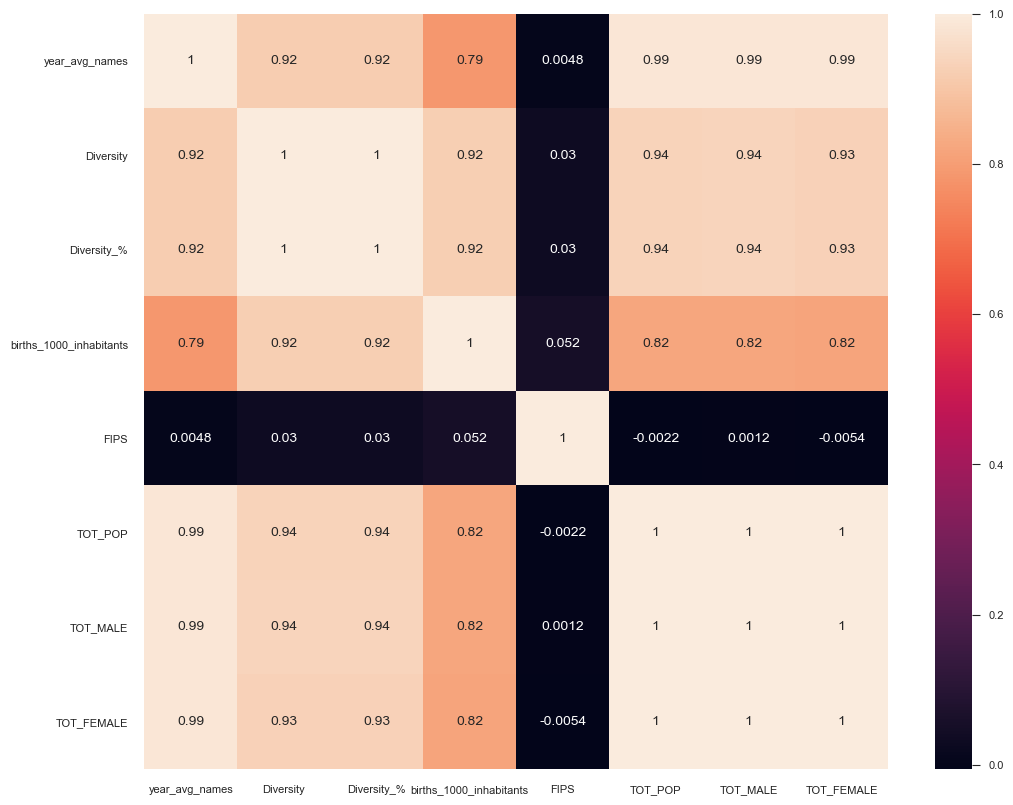

In [82]:
corrMatrix = county_numeric_variables.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### 1.5. Clustering analysis of the counties 
#### 1.5.1 Distribution of names in each county

In [83]:
names_distribution_county = names.groupby(['County','First_Name'])['Count'].sum().reset_index().sort_values(by='Count', ascending=False)
# Calculate the proportion of each name in each county and compare it to the proportion of each name in the whole NY state
total_names_county = names.groupby(['County'])['Count'].sum().reset_index().sort_values(by='Count', ascending=False)
total_names_county.columns = ['County', 'County_Count']
names_distribution_county = pd.merge(names_distribution_county,total_names_county, how = 'left', on = 'County')
names_distribution_county['Name_per_County_%'] = names_distribution_county['Count'] / names_distribution_county['County_Count'] * 100
names_distribution_county = pd.merge(names_distribution_county,state_names_distribution[['First_Name','Count_%']],on='First_Name')
names_distribution_county = names_distribution_county.rename(columns = {'Count_%':'Name_State_%'})
names_distribution_county.head()
dtale.show(names_distribution_county,ignore_duplicate=True)

#### 1.5.2 Which county may be more representative of the whole NY state in terms of name distribution?

**Findings from the dataset:** 

- **less names per capita:** As detailed in the previous analysis, there are some counties that have much less names per capita than they should have and much less than the rest of the counties. This is clear with the births_1000_inhabitants calculation. 
- **sudden decrease in 2010:** Specifically, those counties have also a weird sudden decrease in the baby names registration in the year 2010.
- **high proportion of male names:** male names are representated in around 60% whereas females have 40%. This trends is similar among years and counties

**Assumptions**

- Even with these errors in the data, to find the NY county that is more similar with the NY state name distribution all counties should be included since it can be supposed that those names included are similar to the real distribution of names we would have with all the observations.




In [84]:
names_distribution_county['delta'] = names_distribution_county['Name_per_County_%'] - names_distribution_county['Name_State_%']
# the deltas could cancel out the difference between the 2 proportions. We need to compute the distance --> apply absolute value
names_distribution_county['delta_abs'] = names_distribution_county['delta'].abs()
names_distribution_county.head()

,County,First_Name,Count,County_Count,Name_per_County_%,Name_State_%,delta,delta_abs
0,KINGS,DAVID,1605,136654,1.174499,0.858183,0.316316,0.316316
1,QUEENS,DAVID,934,95624,0.976742,0.858183,0.118559,0.118559
2,BRONX,DAVID,559,58554,0.954674,0.858183,0.096491,0.096491
3,NEW YORK,DAVID,390,58861,0.662578,0.858183,-0.195606,0.195606
4,NASSAU,DAVID,387,57111,0.677628,0.858183,-0.180556,0.180556


**Calculation using all names**

In [85]:
county_name_distribution_distance = names_distribution_county.groupby('County')['delta_abs'].sum().reset_index().sort_values(by='delta_abs', ascending=True)
county_name_distribution_distance.head()

,County,delta_abs
58,WESTCHESTER,26.393846
28,NASSAU,29.787769
50,SUFFOLK,30.833282
39,QUEENS,33.492824
34,ORANGE,37.766040


In [86]:
county_name_distribution_distance = names_distribution_county.groupby('County')['delta_abs'].mean().reset_index().sort_values(by='delta_abs', ascending=True)
county_name_distribution_distance.head()

,County,delta_abs
50,SUFFOLK,0.036446
28,NASSAU,0.037802
58,WESTCHESTER,0.040296
39,QUEENS,0.045818
22,KINGS,0.047271


**The counties that differ less from the proportion of names of NY state are WESTCHESTER, NASSAU, SUFFOLK and QUEENS.** They are, in that order, the ones more close to the NY distribution of names and also the ones with less dispersion, i.e., the ones that differ less from the real proportion on average. 

However, this calculation is highly affected by the fact that many states have so few baby names that their distribution is not representative of their real one. For instance, SCHUYLER, since it has only 1 baby name in this dataset from 2007 to 2012 it is very far from the NY state distribution.

In [87]:
county_name_distribution_distance.tail()

,County,delta_abs
45,SCHOHARIE,10.500263
23,LEWIS,11.855818
15,ESSEX,13.681767
60,YATES,32.477521
46,SCHUYLER,99.157203


#### 1.5.3 Which counties can be grouped together in terms of the name distribution?

**Assumptions**

- Those counties with a very low births_1000_inhabitants (KINGS has the highest with 8.87) may be don't have a representative of their real distribution of names and they may distort the clustering results. 
    - **Exclude those that have less than 3**

- Those counties with the decrease in names in 2010 (usually to 0) and that have so few names could be filtered when segmenting counties to find couties with similar name distribution. 
     - They can be singled out by using the categorical variable Decrease_pop_2010
     - Doing this only 10 counties remain. The previous assumption is restrictive enough
- To agilize the analysis and reduce calculations, **the analysis should include only those names more popular in the whole NY state**
    - The cutoff can be between 200-400 more popular names depending the computational needs of the model that would result
    
**Methodology**

- Using PCA to reduce the number of variables(which will be the proportion of each name)
- Clustering using K-means with the PC variables (it would work also using hieralchical clustering)

Since the number of counties is still low (60) the analysis could be performed with all the names as variables, however, if the same analysis would be done with all the counties of the USA then this method would reduce a lot the computational time

In [88]:
# names_distribution_county dataframe with most common names
names_distribution_county_filter = pd.merge(names_distribution_county, counties_pop_decrease, on='County')
# names_distribution_county_filtered = names_distribution_county_filter[names_distribution_county_filter['Decrease_2010_pop'] == False]
# names_distribution_county_filtered
names_distribution_county_filter = pd.merge(names_distribution_county, county_births_1000_inhabitants, on='County')
names_distribution_county_filtered = names_distribution_county_filter[names_distribution_county_filter['births_1000_inhabitants'] > 3]
# names_distribution_county_filtered = names_distribution_county_filter
# county_cluster = names_distribution_county_filtered
county_cluster = names_distribution_county_filtered[names_distribution_county_filtered['First_Name'].isin(most_common_names)]

In [89]:
# county_cluster_name is a dataframe constructed to for the clustering. 
# It has the counties as observations and the proportion for each county of the 400 most popular names as variables 
county_cluster_name = county_cluster.pivot(index='County', columns='First_Name', values='Name_per_County_%').reset_index().rename_axis(None, axis=1)
county_cluster_name = county_cluster_name.fillna(0)
# county_cluster_name.columns
# dtale.show(county_cluster_name,ignore_duplicate=True)

In [90]:
county_cluster_name.head()

,County,AALIYAH,AARON,ABIGAIL,ABRAHAM,ADAM,ADDISON,ADRIAN,ADRIANA,ADRIANNA,...,XAVIER,YAKOV,YEHUDA,YISROEL,YITZCHOK,YOSEF,ZACHARY,ZION,ZOE,ZOEY
0,ALBANY,0.197596,0.082332,1.218508,0.000000,0.082332,0.559855,0.000000,0.000000,0.000000,...,0.362259,0.0,0.0,0.0,0.0,0.0,0.658653,0.000000,0.181130,0.181130
1,BRONX,0.370598,0.604570,0.421833,0.073436,0.256174,0.017078,0.633603,0.225433,0.107593,...,0.712163,0.0,0.0,0.0,0.0,0.0,0.133210,0.119548,0.237388,0.088807
2,BROOME,0.278940,0.362622,1.394700,0.000000,0.167364,0.306834,0.000000,0.139470,0.000000,...,0.362622,0.0,0.0,0.0,0.0,0.0,0.529986,0.000000,0.000000,0.000000
3,DUTCHESS,0.093095,0.139643,1.256788,0.000000,0.186191,0.387898,0.000000,0.000000,0.000000,...,0.310318,0.0,0.0,0.0,0.0,0.0,0.651668,0.000000,0.000000,0.108611
4,ERIE,0.241941,0.317351,0.609565,0.000000,0.386476,0.521586,0.100547,0.128825,0.166531,...,0.285930,0.0,0.0,0.0,0.0,0.0,0.527870,0.050273,0.219946,0.226230


**Clustering using PCA & K-Means / Hierachical Clustering** 

Most of the names are slightly correlated between -0.2 and 0.2, with very few names having a strong positevily correlation

In [45]:
X_corr = names_distribution_county_filtered[names_distribution_county_filtered['First_Name'].isin(state_names_distribution.nlargest(30, 'Count')['First_Name'].tolist())]
X_corr = X_corr.pivot(index='County', columns='First_Name', values='Name_per_County_%').reset_index().rename_axis(None, axis=1)
X_corr = X_corr.fillna(0)

corrMatrix = X_corr.corr()
sns.heatmap(corrMatrix, annot=False,cmap='coolwarm')
plt.show()

In [46]:
X = county_cluster_name.copy()
X = X.set_index('County')
X_log =  X.apply(np.log,axis = 1).round(4)
ss = StandardScaler()
X_scaled = ss.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns,index=X.index)
pca = PCA()
principalComponents = pca.fit_transform(X)
features = range(pca.n_components_)

In [ ]:
# Plot the cumulative variance explained by total number of components.
# On this graph we choose the subset of components we want to keep. 
# Generally, we want to keep around 80 % of the explained variance.
plt.figure(figsize = (12,9))
plt.plot(features, pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [ ]:
pca = PCA(n_components = 10)
pca.fit(X)
# df_pca_comp = pd.DataFrame(data = pca.components_,
#                            columns = X.columns.values,
#                            index = ['Component 1', 'Component 2','Component 3','Component 4'])

# # Heat Map for Principal Components against original features. Again we use the RdBu color scheme and set borders to -1 and 1.
# sns.heatmap(df_pca_comp,
#             vmin = -1, 
#             vmax = 1,
#             cmap = 'RdBu',
#             annot = False)
# plt.yticks([0, 1, 2], 
#            ['Component 1', 'Component 2', 'Component 3'],
#            rotation = 45,
#            fontsize = 9)

scores_pca  = pca.transform(X)

In [ ]:
features = range(pca.n_components_)
components_list = []
i = 1
for i in range(1,len(features)+1,1):
    components_list.append('Component '+ str(i))


In [ ]:
county_cluster_name = pd.concat([county_cluster_name, pd.DataFrame(scores_pca)], axis = 1)
county_cluster_name.columns.values[-len(features): ] = components_list

**There are clearly 3 main differenciated groups, with some subgroups in the bigger 2 groups**

In [ ]:
fig = px.scatter(county_cluster_name, x="Component 1", y="Component 2", )
fig.update_layout(
    title='Counties by PCA Components',
    xaxis_title="Component 1",
    yaxis_title="Component 2",
    font=dict(
        size=15,
    ))
fig.show()

### K-Means Clustering 

In [ ]:
sse={}

X_kmeans = X.copy()


for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(scores_pca)
    X_kmeans["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

The elbow graph shows a steep decrease since the number 5 of clusters

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(scores_pca)
county_cluster_name['Kmeans_Cluster'] = kmeans.predict(scores_pca)

In [ ]:
sns.set_palette("Set1", 8, .75)
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = county_cluster_name['Component 1']
y_axis = county_cluster_name['Component 2']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = county_cluster_name['Kmeans_Cluster'],palette="deep")
plt.title('Clusters by PCA Components')
plt.show()

**Hierarchical Clustering**

In [ ]:
# Using the dendrogram to find the optimal numbers of clusters. 
# First thing we're going to do is to import scipy library. scipy is #an open source Python library that contains tools to do #hierarchical clustering and building dendrograms. Only import the #needed tool.

#Lets create a dendrogram variable linkage is actually the algorithm #itself of hierarchical clustering and then in linkage we have to #specify on which data we apply and engage. This is X dataset
dendrogram = sch.dendrogram(sch.linkage(scores_pca, method  = "ward"))

plt.title('Dendrogram')
plt.xlabel('Counties')
plt.ylabel('Euclidean distances')
plt.show()

In [ ]:
# There are two algorithms for hierarchical clustering: #Agglomerative Hierarchical Clustering and 
# Divisive Hierarchical Clustering. We choose Euclidean distance and ward method for our algorithm class
hc = AgglomerativeClustering(n_clusters = 8, affinity = 'euclidean', linkage ='ward')
# Lets try to fit the hierarchical clustering algorithm  to dataset #X while creating the clusters vector that tells for each customer #which cluster the customer belongs to.
hc.fit(scores_pca)

# The last column we add contains the pca k-means clustering labels.
county_cluster_name['HC_Cluster'] = hc.labels_

In [ ]:
sns.set_palette("Set1", 8, .75)
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = county_cluster_name['Component 1']
y_axis = county_cluster_name['Component 2']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = county_cluster_name['HC_Cluster'],palette="deep")
plt.title('Clusters by PCA Components')
plt.show()

**Visualization of the clustering**

In [ ]:
county_visualization_cluster = pd.merge (county_numeric_variables, county_cluster_name[['County','Kmeans_Cluster','HC_Cluster']], on='County')


In [ ]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
                   dtype={"fips": str})

fig = px.choropleth_mapbox(county_visualization_cluster, geojson=counties, locations='FIPS', color='Kmeans_Cluster',
                           color_continuous_scale="Viridis",
                           range_color=(0, 4), hover_data  = ['County','births_1000_inhabitants','year_avg_names','Diversity'],
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'Kmeans_Cluster':'cluster rate'},
                          title='County_Clustering_Names_K_means')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_geos(fitbounds="locations", visible=True)
fig.show()
pyoff.plot(fig, filename = 'County_Clustering_Names_K_means.html', auto_open=True)

<a name="origin-distrib-overview"></a>

## 2. Name origin overview

### 2.1. Most common origin present in the whole state of NY


**Evolution of the names origin per year**

In [ ]:
names.head()

In [ ]:
origin_names_distribution = names.groupby(['Origin'])['Count'].sum().reset_index()
origin_names_distribution['Count_%'] = origin_names_distribution['Count'] / origin_names_distribution['Count'].sum() * 100
origin_names_distribution = origin_names_distribution.sort_values(by='Count', ascending=True)

In [ ]:
plt.barh(origin_names_distribution.Origin,origin_names_distribution.Count,log=True)
ax = plt.axes()
plt.title('Origin names count in NY State',fontsize=25)
plt.axvline(3000, 0,1)
plt.xlabel('Total baby names',fontsize=15)
plt.ylabel('Origin',fontsize=20)
plt.xticks(fontsize=14)
ax.xaxis.set_major_formatter(plt.ScalarFormatter())

Most of the names mantain their level year after year. **The most popular name origin (Dutch) has a decrease from 10k in 2007 to 8 k in 2012**

In [ ]:
origin_names_year = names.groupby(['Year','Origin'])['Count'].sum().reset_index()
most_common_origin = origin_names_distribution.nlargest(10, 'Count')['Origin'].tolist()

sns.lineplot(x='Year', y='Count', data=origin_names_year[origin_names_year['Origin'].isin(most_common_origin)], hue = 'Origin')
plt.title('Names per year and origin (10 most popular)',fontsize=25)
plt.xlabel('Month',fontsize=15)
plt.ylabel('Total Babies',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
sns.lineplot(x='Year', y='Count', data=origin_names_year[~origin_names_year['Origin'].isin(most_common_origin)], hue = 'Origin')
plt.title('Names per year and origin (10 to 50 most popular)',fontsize=25)
plt.xlabel('Month',fontsize=15)
plt.ylabel('Total Babies',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### 2.2. Distribution of the most comon origin name in NY State (Dutch) by County

In [ ]:
origin_names_distribution_county = names.groupby(['County','Origin'])['Count'].sum().reset_index().sort_values(by='Count', ascending=False)
# Calculate the proportion of each name in each county and compare it to the proportion of each name in the whole NY state
# total_names_county = names.groupby(['County'])['Count'].sum().reset_index().sort_values(by='Count', ascending=False)
# total_names_county.columns = ['County', 'County_Count']
origin_names_distribution_county = pd.merge(origin_names_distribution_county,total_names_county, how = 'left', on = 'County')
origin_names_distribution_county['Name_per_County_%'] = origin_names_distribution_county['Count'] / origin_names_distribution_county['County_Count'] * 100
# origin_names_distribution_county.sort_values(by=['County','Count'], ascending=False)
origin_names_distribution_county.head()

In [ ]:
county_distribution_dutch = origin_names_distribution_county[origin_names_distribution_county['Origin'] == 'Dutch']
county_distribution_dutch = pd.merge(county_distribution_dutch,county_data[['County','FIPS']], how = 'left', on = 'County')

In [ ]:
county_distribution_dutch.head()

In [ ]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
                   dtype={"fips": str})

fig = px.choropleth_mapbox(county_distribution_dutch, geojson=counties, locations='FIPS', color='Name_per_County_%',
                           color_continuous_scale="Jet",
                           range_color=(0, 25), hover_data  = ['County','Name_per_County_%'],
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'Name_per_County_%':'Name origin Dutch (%)'})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_geos(fitbounds="locations", visible=True)
fig.show()
pyoff.plot(fig, filename = 'Origin_name_Dutch_Distribution.html', auto_open=True)

county_distribution_dutch

### 2.3. Most common name origin by county and year

In [ ]:
origin_names_distribution_county.head()

In [ ]:
most_frequent_origin_county = origin_names_distribution_county.groupby(['County'])['Count','Origin','County_Count','Name_per_County_%'].first().reset_index()
most_frequent_origin_county = pd.merge(most_frequent_origin_county,county_data[['County','FIPS']], how = 'left', on = 'County')

In [ ]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
                   dtype={"fips": str})

fig = px.choropleth_mapbox(most_frequent_origin_county, geojson=counties, locations='FIPS', color='Origin',
                           color_continuous_scale="Jet",
                            hover_data  = ['County','Name_per_County_%','Origin'],
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'Origin%':'Origin'})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_geos(fitbounds="locations", visible=True)
fig.show()
pyoff.plot(fig, filename = 'Most common name origin by county.html', auto_open=True)


In [ ]:
origin_names_distribution_county_year = names.groupby(['County','Origin','Year'])['Count'].sum().reset_index().sort_values(by='Count', ascending=False)
total_origin_county_year = names.groupby(['County','Year'])['Count'].sum().reset_index().sort_values(by='Count', ascending=False)
total_origin_county_year.columns = ['County', 'Year','County_Count']
origin_names_distribution_county_year = pd.merge(origin_names_distribution_county_year,total_origin_county_year, how = 'left', on = ['County','Year'])
origin_names_distribution_county_year['Name_per_County_%'] = origin_names_distribution_county_year['Count'] / origin_names_distribution_county_year['County_Count'] * 100
most_frequent_origin_county_year = origin_names_distribution_county_year.groupby(['County','Year'])['Count','Origin','County_Count','Name_per_County_%'].first().reset_index()
most_frequent_origin_county_year = pd.merge(most_frequent_origin_county_year,county_data[['County','FIPS']], how = 'left', on = 'County')
most_frequent_origin_county_year.head()


In [ ]:
most_frequent_origin_county_year

**Tests**

In [ ]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
                   dtype={"fips": str})

fig = px.choropleth(most_frequent_origin_county_year, geojson=counties, locations='FIPS', color='Origin',
                           facet_col = 'Year',
                           color_continuous_scale="Jet",
                           hover_data  = ['County','Name_per_County_%','Origin'],
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'Origin%':'Origin'})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_geos(fitbounds="locations", visible=True)
fig.show()
pyoff.plot(fig, filename = 'Most common name origin by county and year (facet).html', auto_open=True)


In [ ]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
                   dtype={"fips": str})

fig = px.choropleth_mapbox(most_frequent_origin_county_year, geojson=counties, locations='FIPS', color='Origin',
                           color_continuous_scale="Jet",
                            hover_data  = ['County','Name_per_County_%','Origin'],
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'Origin%':'Origin'},animation_frame='Year',animation_group = 'Origin')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_geos(fitbounds="locations", visible=True)
pyoff.plot(fig, filename = 'Most common name origin by county and year.html', auto_open=True)
# fig.show()
# pyoff.plot(fig, filename = 'Most common name origin by county and year.html', auto_open=True)

